In [27]:
%matplotlib inline
import sys
sys.path.append('/u/ki/mbaumer/random_pixel_size/weak_sauce/code')
import weak_sauce as ws
import weak_sauce.data_tools
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

from weak_sauce.movers import UniformGaussianMover
from weak_sauce.grid import MoveableGrid
from weak_sauce.sources import Source
from weak_sauce.movers import UniformIlluminationMover, FixedIlluminationMover
from weak_sauce.fit_flat import FlatFitter

from astropy.io import fits
full_amp_img = fits.getdata('/nfs/slac/g/ki/ki19/des/mbaumer/DES_flatcor_supercal/coadds/coadd_r_04.fits')
print full_amp_img.shape

(4096, 2048)


In [28]:
import matplotlib.colors as colors
from numpy import ma

In [29]:
#data_mg = MoveableGrid('/nfs/slac/g/ki/ki19/lsst/mbaumer/ccd_mg_model_fits/lsst_amp03_maxit100000_step0.1_decay0.0/best_mg.pkl') 
#full_amp_img = np.load('../data/lsst_ultraflat_75ke_amp3.npy')
#full_amp_img = full_amp_img[100:-100,100:-100]
full_amp_img = full_amp_img[100:-100,100:924]
fitted = ws.data_tools.fitIlluminationVariation(full_amp_img,order=3)
data_rel_flux_map = (full_amp_img-fitted)/fitted+1
#print(data_rel_flux_map.shape,data_mg.source.fluxes.shape)


In [4]:
plt.imshow(small_img)

NameError: name 'small_img' is not defined

[[   6.7    8.5   24.6    7.6    5.6]
 [   7.3   18.3   47.3   17.2    6. ]
 [   7.6   33.2  100.    33.2    7.6]
 [   6.    17.2   47.3   18.3    7.3]
 [   5.6    7.6   24.6    8.5    6.7]]
vert corr: (0.60126229611434023, 0.0)
horiz corr: (0.45521534722668971, 0.0)
diag corr: (0.30297565261178472, 0.0)


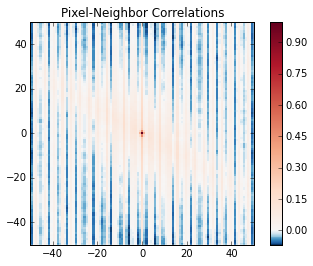

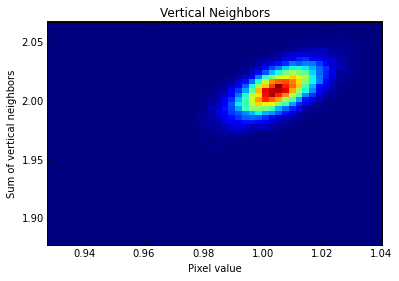

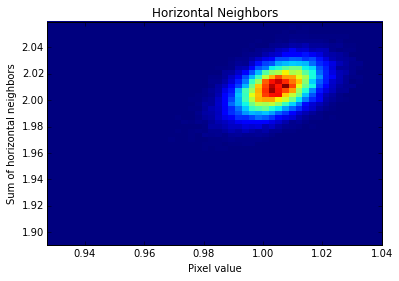

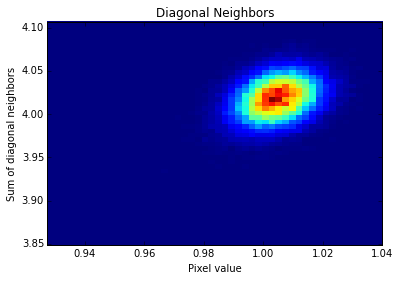

In [7]:
#small_img = ma.masked_where(((data_rel_flux_map < .98) | (data_rel_flux_map > 1.02)),data_rel_flux_map)
#small_img = data_rel_flux_map[400:900,100:200]
#small_img = data_rel_flux_map[800:950,50:200]

corr_arr = weak_sauce.data_tools.makeCorr(small_img,N=50);
weak_sauce.data_tools.neighborScatter(small_img)

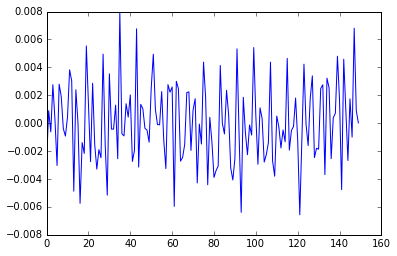

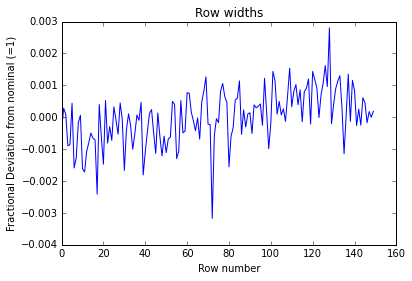

In [10]:
overall_mean = np.mean(small_img)
row_means = np.mean(small_img,axis=1)
col_means = np.mean(small_img,axis=0)
plt.plot(col_means/overall_mean-1)
plt.figure()
plt.plot(row_means/overall_mean-1)
plt.title('Row widths')
plt.xlabel('Row number')
plt.ylabel('Fractional Deviation from nominal (=1)')

In [72]:
f.shape

(400,)

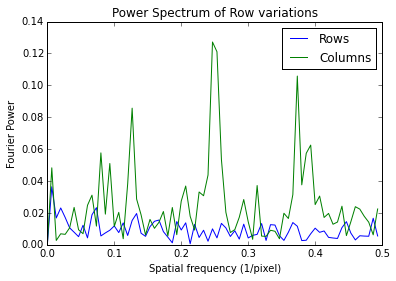

In [9]:
vec = row_means
f = np.fft.fftfreq(vec.size)
plt.plot(f[0:vec.size/2],abs(np.fft.fft(vec/overall_mean-1))[0:vec.size/2],label='Rows')
vec = col_means
f = np.fft.fftfreq(vec.size)
plt.plot(f[0:vec.size/2],abs(np.fft.fft(vec/overall_mean-1))[0:vec.size/2],label='Columns')
plt.title('Power Spectrum of Row variations')
plt.xlabel('Spatial frequency (1/pixel)')
plt.ylabel('Fourier Power')
plt.legend()

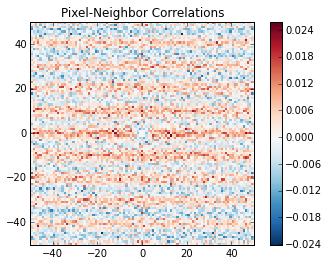

In [61]:
N=50
corr_arr[49:52,49:52] = 0
fig,ax = plt.subplots()
b = np.max(corr_arr)
a = np.min(corr_arr)
c = 0
midpoint = (c - a) / (b - a)
cmap = weak_sauce.data_tools.shiftedColorMap(plt.cm.RdBu_r,midpoint=midpoint)
vmin=a
vmax=b

plt.imshow(corr_arr,interpolation='None',cmap=cmap,extent=(-N,N,-N,N),
           vmin=vmin, vmax=vmax)
plt.title('Pixel-Neighbor Correlations')
#eventually print text in pixels...
#for x_val, y_val in zip(np.arange(11), np.arange(11)):
#    c = np.round(100*corr_arr[y_val,x_val],0)
#    ax.text(y_val, x_val, c, va='center', ha='center')
cbar = plt.colorbar()

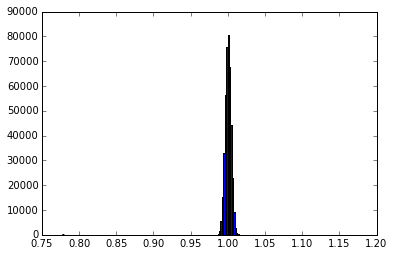

In [13]:
plt.hist(small_img.flatten(),bins=200);

In [8]:
np.std(small_img)

0.0087175854233918892

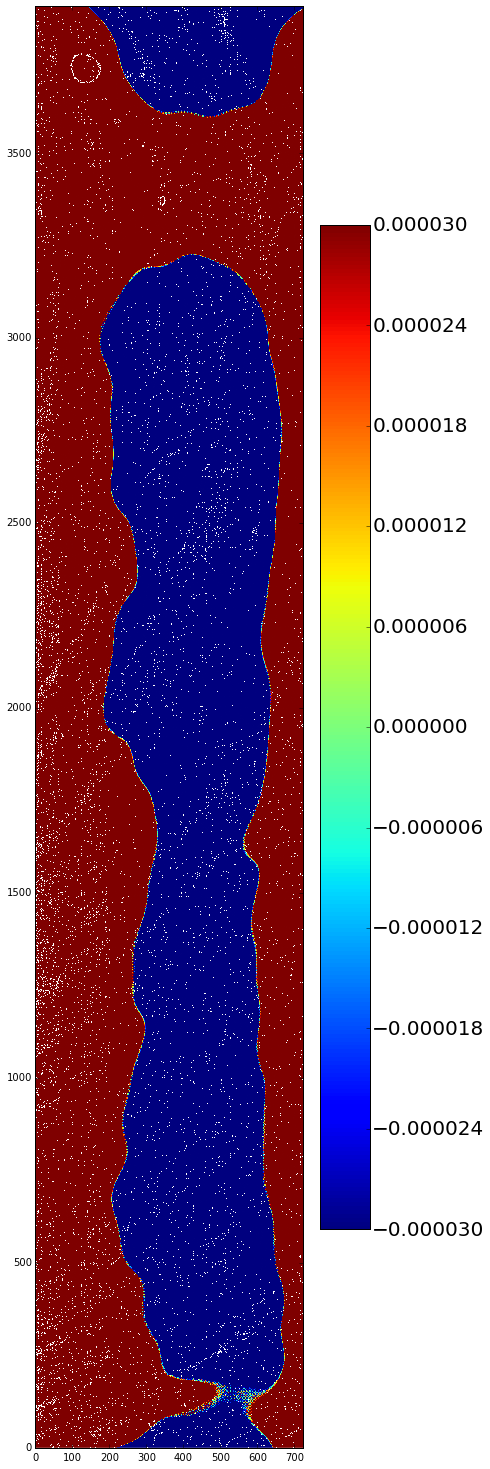

In [39]:
small_img = small_img.transpose()
resid = ma.masked_where(((small_img < .98) | (small_img > 1.02)),small_img - data_mg.source.fluxes)
plt.figure(figsize=(6,30))
im = plt.imshow((resid/small_img).transpose(), interpolation='None',
    norm = colors.Normalize(vmin = -.00003, vmax = .00003, clip = False),
    origin='lower')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20) 

ValueError: need more than 1 value to unpack

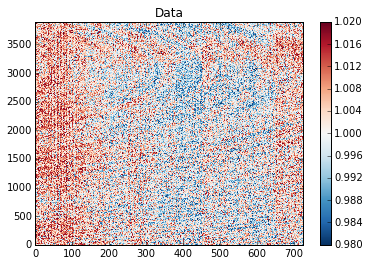

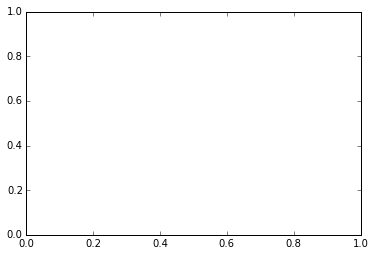

In [40]:
from numpy import ma
#small_img = data_rel_flux_map.transpose()
locs = np.where((small_img < .98) | (small_img > 1.02))
small_img_masked = ma.masked_where(((small_img < .98) | (small_img > 1.02)),small_img)
plotFit(data_mg,small_img_masked)

In [31]:
small_img.shape

(824, 3896)

In [11]:
def runTestAna(small_img):
    data_like_source = Source(num_x=small_img.shape[1]+1,num_y=small_img.shape[0]+1) 
    data_like_source.fluxes += 1 #fit to flat field
    small_img = small_img.transpose()
    data_mg = FlatFitter(data_like_source,small_img)
    data_mg.fit(maxiter=100,verbose=True, step_size=1e-1,learning_rate_decay=0)

    data_mg.source.plot(small_img, pcolormesh_kwargs_in={'linewidths':0})
    plt.title('Data')
    data_mg.source.plot(small_img - data_mg.source.fluxes, pcolormesh_kwargs_in={'linewidths':0})
    plt.title('Data-Model')
    plt.figure()
    plt.title('Image Histograms')
    _ = plt.hist([small_img.flatten(), data_mg.source.fluxes.flatten()],
                 bins=50, histtype='step',label=['Data','Model'])
    plt.legend()
    plt.figure()
    plt.title('Residuals')
    _ = plt.hist((data_mg.source.fluxes - small_img).flatten(),bins=50)
    
def plotFit(data_mg,small_img):
    mask = small_img.mask
    data_mg.source.plot(small_img, pcolormesh_kwargs_in={'linewidths':0})
    plt.title('Data')
    resid = (small_img - data_mg.source.fluxes)[~small_img.mask]
    data_mg.source.plot(resid, pcolormesh_kwargs_in={'linewidths':0})
    plt.title('Data-Model')
    plt.figure()
    plt.title('Image Histograms')
    _ = plt.hist([small_img.flatten(), data_mg.source.fluxes.flatten()],
                 bins=50, histtype='step',label=['Data','Model'])
    plt.legend()
    plt.figure()
    plt.title('Residuals')
    _ = plt.hist((data_mg.source.fluxes - small_img).flatten(),bins=50)

(3696, 624)
0.00824734974261


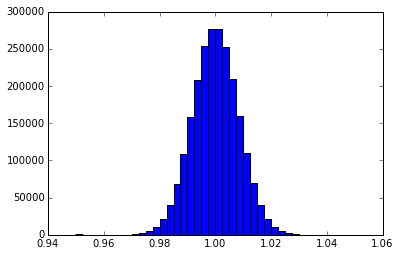

In [15]:
full_amp_img = full_amp_img[100:-100,200:924]
print full_amp_img.shape
fitted = ws.data_tools.fitIlluminationVariation(full_amp_img)
data_rel_flux_map = (full_amp_img-fitted)/fitted+1
_ =plt.hist(data_rel_flux_map.flatten(),bins=40,range=(.95,1.05))
sigma = np.std(data_rel_flux_map)
print sigma

179
(array([   9,   26,   38,   38,   38,   38,   38,   39,   39,   39,   39,
         39,   39,   40,   40,   40,   40,   40,   40,   41,   41,   41,
         41,   42,   42,   42,   42,   43,   43,   51,   65,   71,   72,
         72,   91,   91,  110,  110,  110,  110,  111,  111,  111,  112,
        112,  112,  113,  113,  113,  114,  114,  114,  114,  114,  115,
        115,  115,  116,  116,  116,  117,  117,  117,  118,  118,  118,
        118,  118,  118,  118,  119,  119,  119,  119,  142,  142,  143,
        143,  212,  213,  260,  261,  261,  262,  272,  285,  320,  437,
        451,  497,  498,  512,  513,  513,  514,  514,  515,  652,  653,
        653,  874,  897, 1277, 1319, 1319, 1473, 1473, 1474, 1474, 1499,
       1614, 1614, 1615, 1964, 1965, 1965, 1965, 1966, 1966, 1966, 2227,
       2228, 2228, 2439, 2459, 2460, 2465, 2465, 2466, 2528, 2541, 2542,
       2542, 2542, 2542, 2542, 2542, 2543, 2543, 2543, 2543, 2543, 2543,
       2543, 2544, 2659, 2719, 2720, 2720, 272

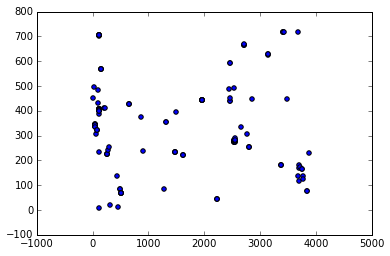

In [37]:
small_img= data_rel_flux_map[:,100:]
mask = np.logical_not(np.logical_and(small_img < np.mean(small_img)+5*sigma,small_img > np.mean(small_img)-5*sigma))
locs = np.where(mask)
print len(locs[0])
plt.scatter(locs[0],locs[1])
print locs

0
-87.4472603715
[ 0.03713909  0.01601898  0.00168862]
1
-70.3293046203
[ 0.03188874  0.01264121  0.00123124]
2
-59.7164318186
[ 0.01193313  0.03930247  0.00092015]
3
-52.8105514335
[ 0.00859605  0.07546111  0.00070412]
4
-48.1169152039
[ 0.00750523  0.00674497  0.00055077]
5
-44.8004403566
[ 0.00643252  0.03011468  0.00043944]
6
-42.3744284482
[ 0.00493672  0.00933011  0.00035689]
7
-40.5440376061
[ 0.00554168  0.02025773  0.00029449]
8
-39.1243504602
[ 0.00575689  0.00560896  0.0002465 ]
9
-37.9957564709
[ 0.01150897  0.03653716  0.00020904]
10
-37.0787249475
[ 0.00742086  0.00815601  0.0001794 ]
11
-36.3190416244
[ 0.01097664  0.00445882  0.00015566]
12
-35.6788977524
[ 0.00241511  0.03159494  0.00013644]
13
-35.1313625434
[ 0.00378414  0.00409883  0.0001207 ]
14
-34.6568704361
[ 0.00221399  0.00616458  0.0001077 ]
15
-34.240940144
[  2.04711950e-03   1.46388108e-01   9.68394654e-05]
16
-33.8726644124
[  1.96971448e-03   1.19536367e-01   8.76892712e-05]
17
-33.5436920016
[  1.812405

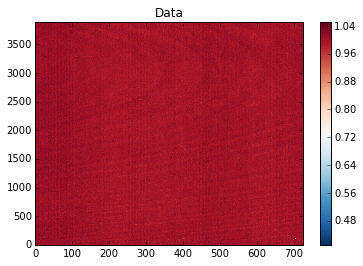

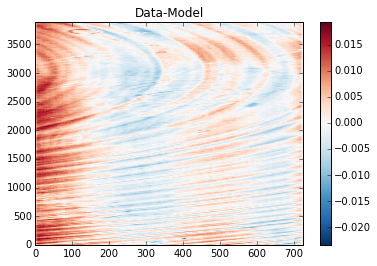

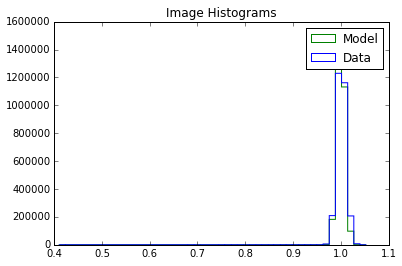

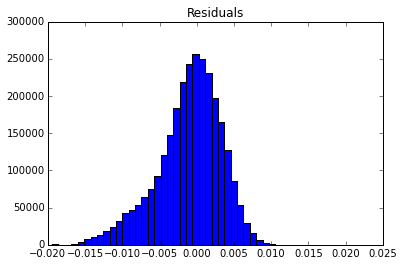

In [25]:
runTestAna(small_img)

Seems like bad pixels might not be such a big deal?

##Fill bad pixels with medians of 8-neighbors

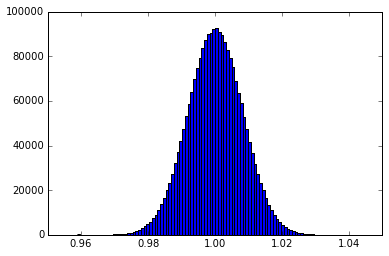

In [17]:
small_img[mask] = 1
_ = plt.hist(small_img.flatten(), bins=100)

maxiter reached


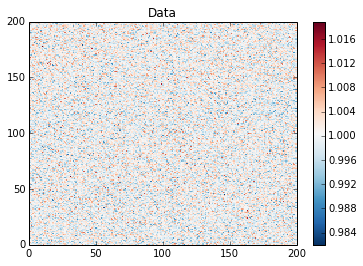

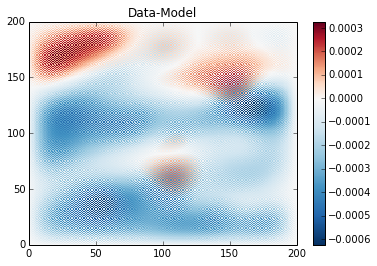

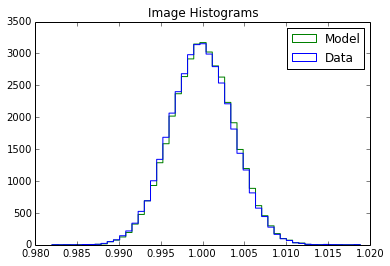

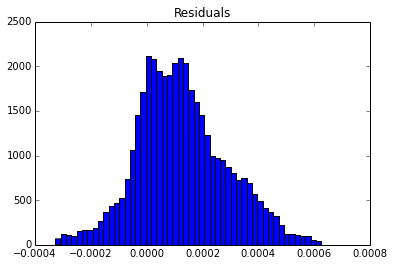

In [38]:
runTestAna(small_img)

So it seems by setting all bad pixels to one, the residuals are slightly better, but they weren't all that bad to begin with. Effects will be more clear on DES...

In [18]:
small_img = small_img.transpose()

ValueError: operands could not be broadcast together with shapes (824,3896) (3896,724) 

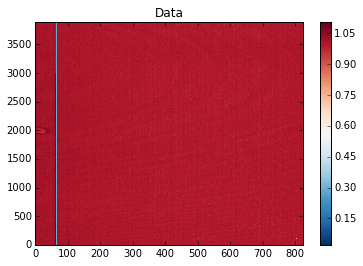

In [36]:
data_mg = MoveableGrid('/nfs/slac/g/ki/ki19/des/mbaumer/ccd_mg_model_fits/des_chip04_maxit2500_step0.5_decay0.0001/mg.pkl')
data_mg.source.plot(small_img, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Data')
resid = small_img - data_mg.source.fluxes.T
resid_masked = ma.masked_where(np.logical_or(resid < -0.01,resid > 0.01), resid)
data_mg.source.plot(resid_masked, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Data-Model')
plt.figure()
plt.title('Image Histograms')
_ = plt.hist([small_img.flatten(), data_mg.source.fluxes.flatten()],
             bins=50, histtype='step',label=['Data','Model'])
plt.legend()
plt.figure()
plt.title('Residuals')
_ = plt.hist((resid_masked).flatten(),bins=50)

In [8]:
mask = np.where(np.logical_or(resid < -0.01,resid > 0.01))
print len(mask[0])

163


(<matplotlib.figure.Figure at 0x7fd634494250>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd6340e56d0>)

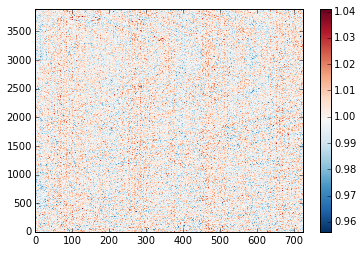

In [33]:
model_masked = ma.masked_where(np.logical_or(resid < -0.01,resid > 0.01),data_mg.source.fluxes.T)
data_mg.source.plot(model_masked.T, pcolormesh_kwargs_in={'linewidths':0})

In [16]:
ideal_source = Source(num_x=small_img.shape[1]+1,num_y=small_img.shape[0]+1) 

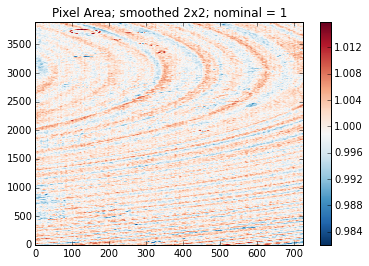

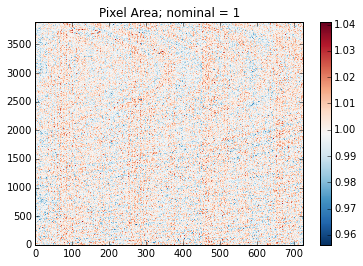

In [34]:
from matplotlib.colors import LogNorm
from scipy import ndimage
data_mg.source.plot(ndimage.gaussian_filter(data_mg.source.fluxes, sigma=(2,2), order=0), pcolormesh_kwargs_in={'linewidths':0})
plt.title('Pixel Area; smoothed 2x2; nominal = 1')
data_mg.source.plot(data_mg.source.fluxes, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Pixel Area; nominal = 1')

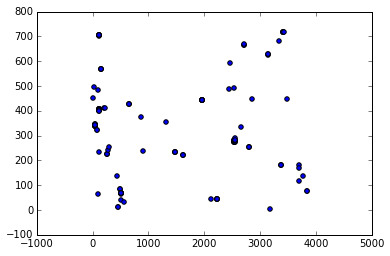

In [24]:
model_masked = ma.masked_where(np.logical_or(resid < -0.01,resid > 0.01),data_mg.source.fluxes.T)
list1 = np.where(model_masked.mask)
plt.scatter(list1[0],list1[1])

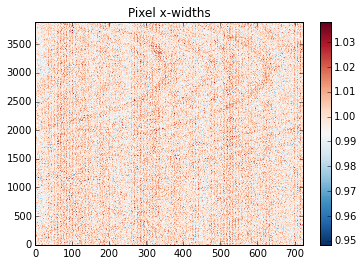

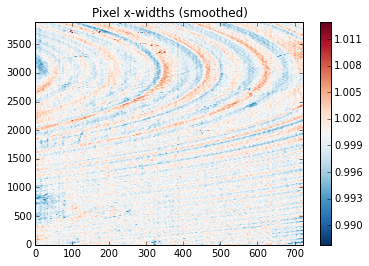

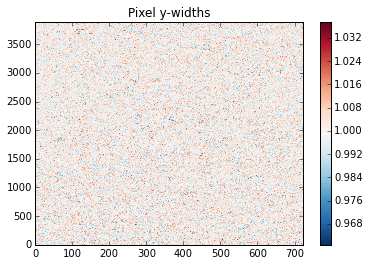

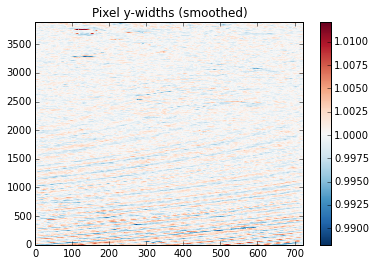

In [30]:
from matplotlib.colors import LogNorm
from scipy import ndimage
data_mg.source.plot((data_mg.source.vertices[:,:,0]-np.roll(data_mg.source.vertices[:,:,0],1,axis=0))[1:-1,1:-1], pcolormesh_kwargs_in={'linewidths':0})
plt.title('Pixel x-widths')
data_mg.source.plot(ndimage.gaussian_filter((data_mg.source.vertices[:,:,0]-np.roll(data_mg.source.vertices[:,:,0],1,axis=0))[1:-1,1:-1], sigma=(2,2), order=0), pcolormesh_kwargs_in={'linewidths':0})
plt.title('Pixel x-widths (smoothed)')
data_mg.source.plot((data_mg.source.vertices[:,:,1]-np.roll(data_mg.source.vertices[:,:,1],1,axis=1))[1:-1,1:-1], pcolormesh_kwargs_in={'linewidths':0})
plt.title('Pixel y-widths')
data_mg.source.plot(ndimage.gaussian_filter((data_mg.source.vertices[:,:,1]-np.roll(data_mg.source.vertices[:,:,1],1,axis=1))[1:-1,1:-1], sigma=(2,2), order=0), pcolormesh_kwargs_in={'linewidths':0})
#plt.scatter(list1[1],list1[0])
plt.title('Pixel y-widths (smoothed)')

(array([  2.00000000e+00,   1.00000000e+00,   4.00000000e+00,
          3.00000000e+00,   4.00000000e+00,   6.00000000e+00,
          1.20000000e+01,   1.30000000e+01,   1.10000000e+01,
          1.40000000e+01,   3.10000000e+01,   4.40000000e+01,
          6.40000000e+01,   7.40000000e+01,   7.80000000e+01,
          9.60000000e+01,   1.13000000e+02,   1.18000000e+02,
          1.82000000e+02,   2.72000000e+02,   3.56000000e+02,
          4.29000000e+02,   5.63000000e+02,   6.78000000e+02,
          8.77000000e+02,   1.10800000e+03,   1.31300000e+03,
          1.80600000e+03,   2.31800000e+03,   2.96500000e+03,
          3.89100000e+03,   5.19100000e+03,   6.75000000e+03,
          8.85700000e+03,   1.09080000e+04,   1.39970000e+04,
          1.76850000e+04,   2.24530000e+04,   2.84070000e+04,
          3.59820000e+04,   4.55900000e+04,   5.78260000e+04,
          7.27370000e+04,   9.29180000e+04,   1.19439000e+05,
          1.48488000e+05,   1.81193000e+05,   2.09521000e+05,
        

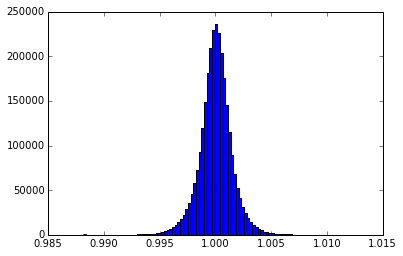

In [29]:
plt.hist(ndimage.gaussian_filter((data_mg.source.vertices[:,:,1]-np.roll(data_mg.source.vertices[:,:,1],1,axis=1))[1:-1,1:-1], sigma=(2,2), order=0).flatten(),bins=100);

In [19]:
ideal_source.vertices.shape

(725, 3897, 2)